# GeoPandas
    <Taylor Rubalcava>
    <Feb 13>

In [19]:
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
from shapely.geometry import Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation

Reading in the file *airports.csv* via Pandas
Creating three convex hulls around the three sets of airports listed below.

Then, creating a new GeoDataFrame using a dictionary with key *'geometry'* and with a list of these three Polygons as the value.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport

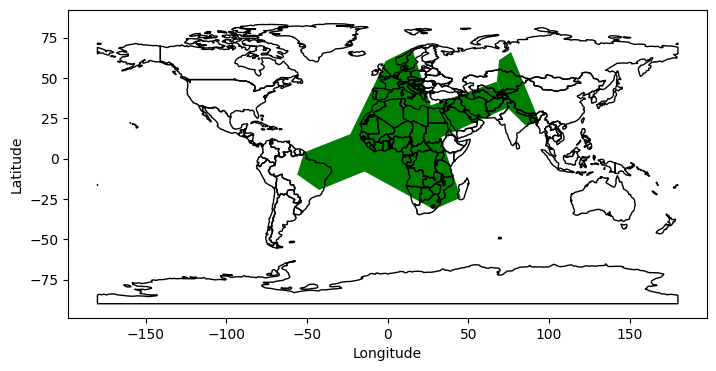

In [20]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport', 'K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport', 'Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport', 'RAF Ascension Island', 'Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport', 'Khanty Mansiysk Airport', 'Novy Urengoy Airport',
                 'Kalay Airport', 'Biju Patnaik Airport', 'Walton Airport']

# Reading in the data as a GeoDataFrame
geo_data = gpd.read_file("./Data/worldmap.gpkg")

# Reading in the airports.csv as a pandas Data Frame
airports_data = pd.read_csv("./Data/airports.csv")

# Getting the coordinates to create the convex hulls
airports_data_one = airports_data[airports_data["Name"].isin(first_set)]
airports_data_two = airports_data[airports_data["Name"].isin(second_set)]
airports_data_three = airports_data[airports_data["Name"].isin(third_set)]

# Creating the polygons
first_polygon = Polygon(list(zip(airports_data_one.Longitude, airports_data_one.Latitude))).convex_hull
second_polygon = Polygon(list(zip(airports_data_two.Longitude, airports_data_two.Latitude))).convex_hull
third_polygon = Polygon(list(zip(airports_data_three.Longitude, airports_data_three.Latitude))).convex_hull

# Creating a new GeoDataFrame using a diction with key "geometry"
geometry_dictionary = {"geometry": [first_polygon, second_polygon, third_polygon]}
dictionary_geo_frame = gpd.GeoDataFrame(geometry_dictionary)
dictionary_geo_frame.set_geometry("geometry")

# Plotting this new GeoDataFrame
fig,ax = plt.subplots(1, figsize=(10,4))
base = geo_data.boundary.plot(edgecolor = "black", ax=ax, linewidth = 1)
dictionary_geo_frame.plot(ax=base, color = "green", markersize = 10)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


Using the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Using this to **plot the boundaries of all US counties two times**, first using the default CRS and then using EPSG:5071.

Making a new GeoDataFrame that combines (*dissolve*) all counties within each state (*by='STATEFP'*).
Droping regions with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.

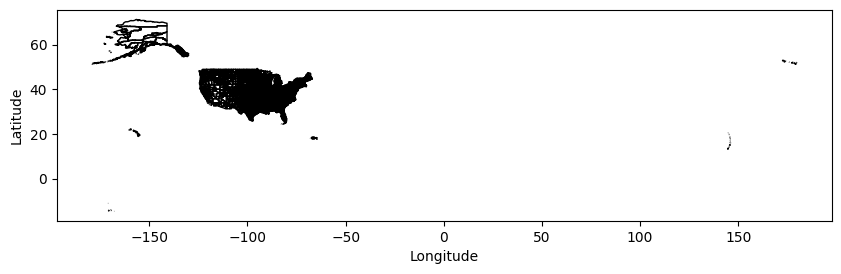

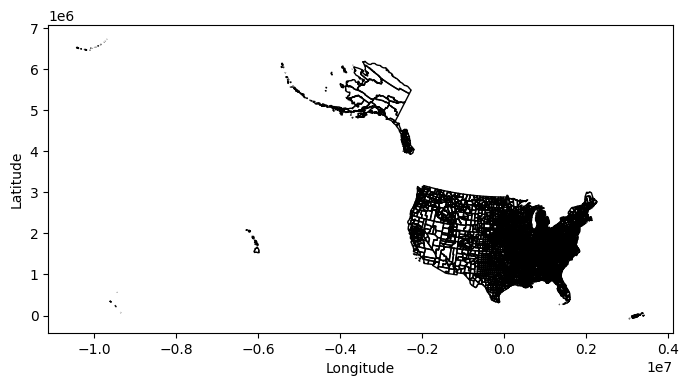

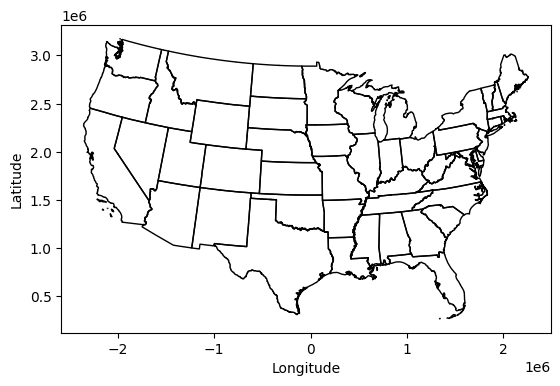

In [21]:
# Loading the county data
county_data = gpd.read_file("./Data/county_data.gpkg")

# Each county's shape is stored in the geometry column.
# Plotting the boundaries of all the counties twice, once using the default CRS
fig,ax = plt.subplots(1, figsize=(10,4))
base = county_data.boundary.plot(edgecolor = "black", ax=ax, linewidth = 1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# and then using EPSG:5071
fig,ax = plt.subplots(1, figsize=(10,4))
base = county_data.to_crs(epsg=5071).boundary.plot(edgecolor = "black", ax=ax, linewidth = 1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# Creating a new GeoDataFrame that combines (dissolve)s all counties within each state
combined_data_frame = county_data[~county_data["STATEFP"].isin(['02','15','60','66','69','72','78'])]
combined_data_frame = combined_data_frame.dissolve(by="STATEFP")

# Plotting the new GeoDataFrame
fig,ax = plt.subplots(1, figsize=(10,4))
base = combined_data_frame.to_crs(epsg=5071).boundary.plot(edgecolor = "black", ax=ax, linewidth = 1)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

Loading in the file *nytimes.csv* as a Pandas DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.

Merge the county GeoDataFrame from *county_data.gpkg* with the *nytimes* DataFrame on the county *fips* codes (a FIPS code is a 5-digit unique identifier for geographic locations).

Droping the regions from the county GeoDataFrame with the same STATEFP codes.

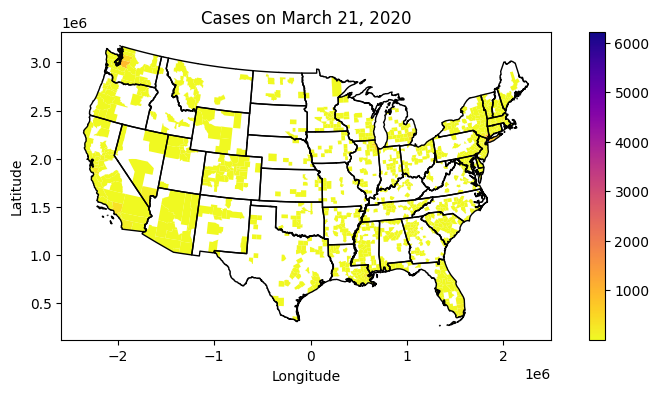

In [22]:
# Loading the nytimes.csv as a Pandas DataFrame
nytimes = pd.read_csv("./Data/nytimes.csv")

# Getting the filtered county_data
county_data = county_data[~county_data["STATEFP"].isin(['02','15','60','66','69','72','78'])]

# Changing the CRS fo the county GeoDataFrame to EPSG:5071
county_data = county_data.to_crs(epsg=5071)

# Merging county_data with nytimes via county 'fips' codes
county_data["fips"] = county_data["STATEFP"] + county_data["COUNTYFP"]
county_data["fips"] = county_data["fips"].astype(float)

joint_data = county_data.merge(nytimes, on = "fips")

# Plotting the cases from March 21 with the combined_data_frame on top
fig,ax = plt.subplots(1, figsize=(10,4))
base = combined_data_frame.to_crs(epsg=5071).boundary.plot(edgecolor = "black", ax=ax, linewidth = 1)
joint_data[joint_data["date"] == "2020-03-21"].plot(ax=base, column = "cases", cmap = "plasma_r", legend = True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Cases on March 21, 2020")
plt.show()

Plotting state outline map on top of a map of Covid-19 cases from March 21, 2020 (each with a CRS of EPSG:5071).
This time, however, using a log scale.

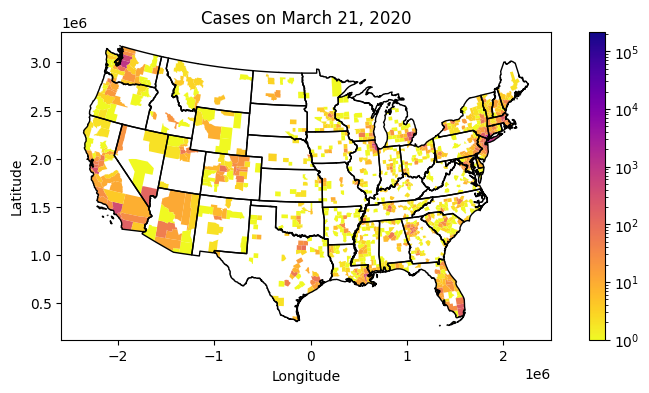

In [23]:
# Loading the nytimes.csv as a Pandas DataFrame
nytimes = pd.read_csv("./Data/nytimes.csv")

# Getting the filtered county_data
county_data = county_data[~county_data["STATEFP"].isin(['02','15','60','66','69','72','78'])]

# Changing the CRS fo the county GeoDataFrame to EPSG:5071
county_data = county_data.to_crs(epsg=5071)

# Merging county_data with nytimes via county 'fips' codes
county_data["fips"] = county_data["STATEFP"] + county_data["COUNTYFP"]
county_data["fips"] = county_data["fips"].astype(float)

joint_data = county_data.merge(nytimes, on = "fips")

# Setting the norm
norm = LogNorm(vmin=min(joint_data.cases), vmax = max(joint_data.cases))

# Plotting the cases from March 21 with the combined_data_frame on top
fig,ax = plt.subplots(1, figsize=(10,4))
base = combined_data_frame.to_crs(epsg=5071).boundary.plot(edgecolor = "black", ax=ax, linewidth = 1)
joint_data[joint_data["date"] == "2020-03-21"].plot(ax=base, column = "cases", cmap = "plasma_r", legend = True, norm=norm)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Cases on March 21, 2020")
plt.show()

Creating an animation of the spread of Covid-19 through US counties from January 21, 2020, through June 21, 2020.

In [24]:
plt.ioff()

fig, ax = plt.subplots(1, figsize=(10, 7))

# Setting the norm
norm = LogNorm(vmin=min(joint_data.cases), vmax = max(joint_data.cases))

def update(date):
    ax.clear()
    # Plot the cases by county from the specified date
    # Plot the state outlines
    base = combined_data_frame.to_crs(epsg=5071).boundary.plot(edgecolor = "black", ax=ax, linewidth = 1)
    joint_data[joint_data["date"] == date].plot(ax=base, column = "cases", cmap = "plasma_r", norm=norm)
    ax.set_title("Covid 19 Cases in the US from Jan. 21, 2020 to June 21, 2020")

cbar = fig.colorbar(ScalarMappable(norm = norm, cmap = "magma_r"), ax = ax, orientation = "horizontal", pad = 0, label = 'Cases')

# Create animation object
ani = animation.FuncAnimation(fig, update, frames=sorted(set(joint_data['date'])), interval=1000*(1/30)) # Each frame is 1/30 of a second
plt.close(fig)

In [26]:
animation.writer = animation.writers['ffmpeg']

# Saving the animation
ani.save('./Media/covid_spread.mp4')

<video src="covid_spread.mp4" controls>